## 전처리 (Normalization)
- 특수문자는 '…'과 '·', ',' ''', '.', '=', '\n' 제거.

---

## 전처리 (Tokenization)
- **konlpy 의 Mecab**를 사용 
  : 숫자, 특수문자 처리, 복합어에 대한 토큰화 등을 이유로 선택함. 
- 분절된 토큰의 길이가 1이상인 경우에만 사용 
- 형태소 분석 결과에서 **동사, 명사인 토큰만** 사용함 : 기타 POS(부사 등)는 내용과 무관하게 산재하여 있을 확률이 높으므로 제외함.

## Vocab 만들기
- TorchText 를 이용하여 Train Data 와 Test Data 를 구성
- Train Data 만으로 build_vocab 함수를 이용하여 vocab 를 구성
    - Test Data 는 vocab 을 만들 떄 사용되지 않는다.
- **{토큰:(0~vocab크기)} 의 dictionary** 로 vocab 을 구현함
- **vocab 수 : 18796**
---

## MAX SEQ LEN
- 전체 데이터셋에 대해서 sequence 의 길이를 통일해야 하기 때문에 전체 데이터의 sequence 길이 분포를 조사함
- max_seq_len: 544, mean_seq_len: 175.5125
- sequence 의 길이가 길면 길수록 담고 있는 정보량은 많아지지만, 반대로 모델이 그만큼 학습해야 할 정보가 늘어남
- 즉, 평균이 175인데, 최대 길이인 544로 길이를 통일하게 되면 너무 많은 입력이 0(padding)으로 나타나기 때문에 의미 없는 정보가 늘어남
- 256 단어로 텍스트를 분류하는데 큰 문제가 없다고 판단되어, **문장의 max_seq_len 은 256**로 설정하여 길이를 통일하도록 함
---


## 실험 1. TextCNN [http://emnlp2014.org/papers/pdf/EMNLP2014181.pdf](Convolutional Neural Networks for Sentence Classification)
- Word2Vec Embedding 을 이용하여 문장을 표현 -> Embedding [batch_size x max_seq_len x embed_dim]
- 주어진 Embedding 을 바탕으로 Conv1D 연산 진행
    - filter_size 는 2,3,4,5 로 각각 2-gram, 3-gram, 4-gram, 5-gram 에 대한 지역정보를 연산하는 효과를 가짐.
    - Max Pooling 을 하도록 함.
    - 각 filter 에 대하여 나온 feature map 을 concatenation 함
- Conv1D 연산 결과인 concatenation 에 Fully-Connected Network 연산을 진행함. (output_dim = 8, 8개의 클래스를 가지기 때문에)
- Optimizer 로는 Adam, Learning Rate 는 0.001 을 사용함.
- 학습 과정에서 평가한 테스트셋 성능 중 최고 성능은 **[BEST] TEST ACC: 80.94% 임**


---
## 실험 2 : TextLSTM (양방향 LSTM 기반 뉴스 카테고리 분류)
- 주어진 뉴스 기사들은 단어들의 구성으로 순차적인 데이터라는 특성을 가지고 있음. 그렇기 때문에 순차적인 데이터를 연산할 때 사용하는 양방향 LSTM 을 사용함.
- Word2Vec Embedding 을 이용하여 문장을 표현 -> Embedding [batch_size x max_seq_len x embed_dim]
- 주어진 Embedding 을 바탕으로 양방향 LSTM 연산 진행
    - LSTM 연산으로 나오는 양방향 hidden state vector 을 concatenation 한다. 
- 양방향 LSTM 연산 결과인 concatenation 에 Fully-Connected Network 연산을 진행함. (output_dim = 8, 8개의 클래스를 가지기 때문에)
- Optimizer 로는 Adam, Learning Rate 는 0.001 을 사용함.
- 학습 과정에서 평가한 테스트셋 성능 중 최고 성능은 **[BEST] TEST ACC: 78.75% 임**

---
## 성능 비교 및 결론

TextCNN 과 TextLSTM 이라는 뉴스 카테고리 분류를 위한 인공신경망을 구축하고 실험을 진행하였으며 학습 과정에서 평가한 테스트 집합 성능을 기준으로 각각 80.94%, 78.75% 로 TextCNN 이 TextLSTM 대비 2.19% 높았다.

In [1]:
## 필요한 모듈
from konlpy.tag import Mecab
from torchtext.data import Field

import torch
import torch.nn as nn
import torchtext.vocab as vocab

## 데이터 
- 제공되는 데이터는 Naver News 데이터의 헤드라인과 본문을 합친 news 컬럼이 있는 데이터
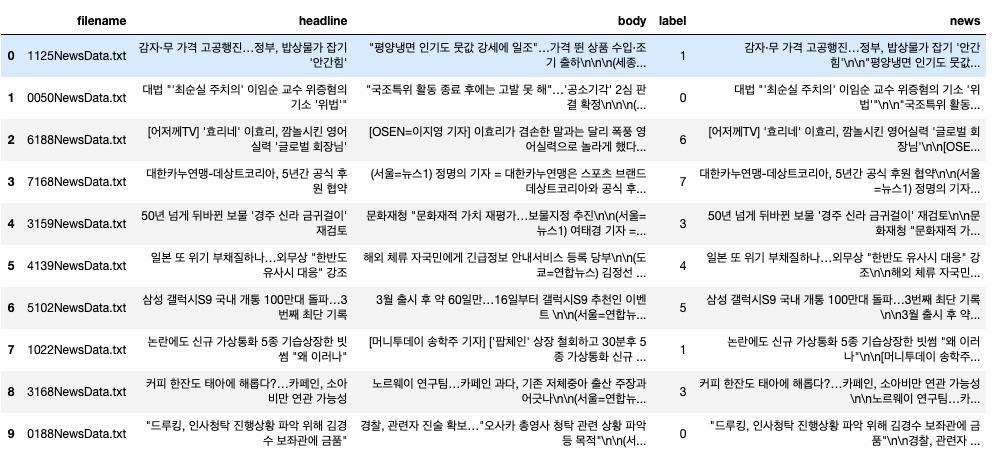

## Tokenizer 구현
- TorchText에서는 기본적으로 string 단위로 토크나이즈 하고, spacy와 같은 외부 토크나이저를 사용할 수 있음
- 한국어의 경우는 형태소 분석을 해야하기 때문에 형태소 분석을 하는 모듈을 FIELD에 포함시켜야 함
- TEXT의 preprocessing으로 연결할 수 있는 형태소 분석 모듈 작성(조교의 이전 프로그램 참조)

In [2]:
# Tokenizer
mecab = Mecab()

In [3]:
def tokenizer(string):
    string.replace(',','')
    string.replace("'","")
    string.replace('.', '')
    string.replace("…", "")
    string.replace("·", "")
    string.replace('=','')
    string.replace('\n','')
    mecab = Mecab()
    nouns = mecab.nouns(string)
    nouns = [a for a in nouns if len(a) > 1]
    return nouns

In [4]:
# TODO: Preprocessing
seq_len = 256

TEXT = Field(
    sequential=True, 
    tokenize=tokenizer, 
    use_vocab=True,
    batch_first=True,
    preprocessing=lambda x: x[:seq_len],
    lower=True)

LABEL = Field(sequential=False,  
              use_vocab=False,   
              preprocessing=lambda x: int(x),
              batch_first=True)

## Data Connecting to Raw Data 
- TorchText를 이용하여, Naver News Data를 불러오고, TEXT, LABEL로 연결
- 불러온 데이터를 train, test 데이터로 나누고(8:2비율) train 데이터로 vocab을 형성
- test 데이터를 포함해서 vocab을 형성하면 안됨!

In [5]:
#전체 데이터를 raw_data로 불러들이기
from torchtext.data import TabularDataset

raw_datafields = [('news', TEXT), ('label', LABEL)]
raw_path = './newsdataCombined.tsv'

raw_data = TabularDataset(
    path=raw_path, 
    format='tsv', 
    fields={'news': ('text', TEXT),
            'label': ('labels', LABEL)})

In [6]:
# TO check imported raw Data
print(f'Number of All examples: {len(raw_data)}')
print(vars(raw_data.examples[0]))
print(len(vars(raw_data.examples[0])['text']))

Number of All examples: 1600
{'text': ['감자', '가격', '고공', '행진', '정부', '밥상', '물가', '안간힘', '평양냉면', '인기', '강세', '일조', '가격', '상품', '수입', '조기', '출하', '세종', '연합뉴스', '이태수', '기자', '감자', '일부', '농산물', '가격', '천정부지', '상승', '밥상', '물가', '대란', '우려', '진정', '정부', '농림', '축산', '식품', '급등', '농산물', '조기', '출하', '골자', '주요', '품목', '수급', '상황', '전망', '향후', '대책', '주요', '농산물', '가격', '안정', '식품', '최근', '농산물', '가격', '한파', '지난달', '일시', '저온', '부족', '작황', '부진', '출하량', '평년', '시세', '감자', '평년', '대비', '시세', '양파', '마늘', '재배', '면적', '증가', '시세', '우려', '설명', '감자', '지난해', '작황', '부진', '저장', '물량', '부족', '올봄', '한파', '생육', '부진', '공급량', '부족', '도매가격', '기준', '한때', '식품', '최근', '시설', '감자', '출하량', '수입', '물량', '추가', '가격', '하향', '추세', '이달', '상순', '도매가격', '기준', '평년', '거래', '가격', '상황', '설명', '정부', '감자', '공급', '부족', '노지', '감자', '출하', '이달', '이전', '수입', '농협', '조기', '출하', '적극', '유도', '방침', '지금', '수입', '감자', '정부', '역시', '한파', '겨울', '저장량', '평년', '공급량', '부족', '상황', '식품', '보도', '자료', '공급량', '절대', '부족', '상황', '최근', '평양냉면', '인기', '육수', '고명', '소비', '일시',

In [7]:
# raw_data를 80:20으로 train_data, test_data로 분리
train_data, test_data = raw_data.split(0.8)

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 1280
Number of testing examples: 320


## Vocab 구축

In [9]:
# embedding dim : [35171 x 100]
# gensim 을 이용하여 Vector 를 불러온다.
from gensim.models import KeyedVectors

w2v_model = KeyedVectors.load_word2vec_format('./NewsAllW2vec.txt', binary=False)

In [10]:
MAX_VOCAB_SIZE = 20000

TEXT.build_vocab(train_data)

In [11]:
# vocab 테스트 

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")

Unique tokens in TEXT vocabulary: 18796


In [12]:
print(TEXT.vocab.freqs.most_common(20))

[('기자', 1091), ('서울', 984), ('한국', 764), ('시간', 652), ('회담', 633), ('미국', 633), ('북한', 627), ('정상', 572), ('이번', 549), ('대표', 545), ('경찰', 538), ('대통령', 535), ('이날', 529), ('조사', 521), ('사람', 519), ('관련', 517), ('때문', 513), ('중국', 498), ('이후', 486), ('우리', 449)]


In [13]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', '기자', '서울', '한국', '시간', '미국', '회담', '북한', '정상']


In [14]:
# Vocab Vector 만들어줌.

from tqdm import tqdm

word2vec_vectors = []
w2v_size = 100

for token, idx in tqdm(TEXT.vocab.stoi.items()):
    if token in w2v_model.wv.vocab.keys():
        word2vec_vectors.append(torch.FloatTensor(w2v_model[token]))
    else:
        word2vec_vectors.append(torch.zeros(w2v_size))
        
TEXT.vocab.set_vectors(TEXT.vocab.stoi, word2vec_vectors, w2v_size)

  0%|          | 0/18796 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':
100%|██████████| 18796/18796 [00:00<00:00, 118671.75it/s]


## Data Load for Training

In [15]:
from torchtext.data import Iterator

BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, test_iterator = Iterator(train_data, batch_size=BATCH_SIZE, repeat=False, device=device), Iterator(test_data, batch_size=BATCH_SIZE, repeat=False, device=device)

## Model 구축
- 사용하고자 하는 모델 구축
- 참고자료에 있는 방법등을 기초로 하여 여러 방법을 시도한 후 가장 성능이 좋은 모델을 선정.
- 이 선정에 대한 자세한 것도 기술해 놓아야 함

In [16]:
# Your model
class TextLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout, pad_idx):
        super(TextLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            bidirectional=True,
                            batch_first=True,
                            dropout=dropout)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 8)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embed = self.embedding(text)
        output, hidden = self.lstm(embed)
        hidden = torch.cat((hidden[0][-2,:,:], hidden[0][-1,:,:]), dim=1)
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
        
        return output

In [18]:
import torch.nn.functional as F


class TextCNN(nn.Module):
    def __init__(self, vocab_size) -> None:
        super(TextCNN, self).__init__()
        self.v = vocab_size
        self.e = 100
        self.nf = 100
        self.ks = [2, 3, 4, 5]
        self.nc = 8
        self.do = 0.15

        self.embedding = nn.Embedding(self.v, self.e, padding_idx=1)
        self.convs = nn.ModuleList([nn.Conv1d(self.e, self.nf, k) for k in self.ks])
        self.dropout = nn.Dropout(self.do)
        self.fc1 = nn.Linear(len(self.ks) * self.nf, self.nc)

    def forward(self, inputs):
        """
        :param inputs: [bs x seq]
        :return:
        """
        # [bs x embed_dim x seq_len]
        e = torch.einsum('ijk->ikj', self.embedding(inputs))
        r = [F.relu(F.max_pool1d(conv(e), seq_len - nf + 1)).squeeze(dim=2)
             for conv, nf in zip(self.convs, self.ks)]

        # [bs x (embed * len(kernel_sizes))]
        r = torch.cat(r, dim=1)

        # [bs x num_class]
        l = self.fc1(self.dropout(r))

        return l

In [19]:
# Model instantiation

EMBEDDING_DIM = 100
VOCAB_SIZE = 18796

# 모델 안에 static 으로 선언해주었음.
text_cnn_model = TextCNN(VOCAB_SIZE)

## 외부 임베딩 모델 통합
- 제공되는 임베딩 파일은 본 뉴스 기사를 word2vec으로 100차원으로 학습하여 text로 저장한 것.
- 이 파일을 불러들여 TorchTExt의 vocab과 vector에 연결할 필요
- gensim에서 제공하는 임베딩파일을 불러들이는 모듈을 사용할 수도 있고, 이 파일을 불러들이는 모둘을 직접 만들 수도 있다
- 형태소 분석 단위가 맞지 않아 없는 어휘들은 차원크기 만큼의 적당한 값으로 채울 필요 (0으로 채우든지 아니면 정규분포를 보이는 랜덤한 값으로 채우든지...)

In [20]:
# TEXT Vocab Vectors 의 형상 확인
print(TEXT.vocab.vectors.shape)

torch.Size([18796, 100])


In [21]:
#불러온 weight를 Embedding에 통합, 복사
pretrained_embedding = torch.FloatTensor(TEXT.vocab.vectors)
text_cnn_model.embedding.weight.data.copy_(pretrained_embedding)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 5.7997e-01, -1.5273e+00,  2.1190e+00,  ..., -2.8508e+00,
         -3.2948e+00, -9.1227e-01],
        ...,
        [-2.6009e-02,  4.3622e-02, -3.1461e-02,  ..., -4.7576e-02,
          1.8395e-02, -6.7845e-02],
        [ 2.3234e-02, -4.5907e-02, -4.3121e-02,  ..., -5.9926e-02,
          2.5498e-02, -9.8300e-04],
        [ 4.4445e-02, -9.8357e-02, -8.6170e-03,  ...,  4.2081e-02,
          8.0863e-02,  4.0774e-02]])

In [22]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

print(f'unk token index: {UNK_IDX}, pad token index: {PAD_IDX}')

text_cnn_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
text_cnn_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

unk token index: 0, pad token index: 1


In [23]:
# parameter 체크
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(text_cnn_model):,} trainable parameters')

The model has 2,023,208 trainable parameters


## Train and test the Model
- train, test accuracy 출력

In [24]:
import torch.optim as optim

optimizer = optim.Adam(text_cnn_model.parameters())
criterion = nn.CrossEntropyLoss()

text_cnn_model = text_cnn_model.to(device)
criterion = criterion.to(device)

In [25]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    correct = 0
    total = 0
    
    model.train()
    
    for batch in iterator:
        batch_sentence = batch.text.to(device)
        batch_label = batch.labels.to(device)
        
        optimizer.zero_grad()
                
        outputs = model(batch_sentence)
        loss = criterion(outputs, batch_label)
        _, predicted = torch.max(outputs.data, 1)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        total += batch_label.size(0)
        correct += (predicted == batch_label).sum().item()
        
    return epoch_loss , correct / total

In [26]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    correct = 0
    total = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            batch_sentence = batch.text.to(device)
            batch_label = batch.labels.to(device)
            
            outputs = model(batch_sentence)
       
            loss = criterion(outputs, batch_label)
            _, predicted = torch.max(outputs.data, 1)
            
            epoch_loss += loss.item()
            total += batch_label.size(0)
            correct += (predicted == batch_label).sum().item()
        
    return epoch_loss , correct / total

In [27]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
N_EPOCHS = 50

best_test_loss = float('inf')

for epoch in tqdm(range(N_EPOCHS)):

    start_time = time.time()
    
    train_loss, train_acc = train(text_cnn_model, train_iterator, optimizer, criterion, device)
    test_loss, test_acc = evaluate(text_cnn_model, test_iterator, criterion, device)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc*100:.2f}%')

  2%|▏         | 1/50 [00:01<00:49,  1.02s/it]

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 17.825 | Train Acc: 40.08%
	 Test. Loss: 4.283 |  Test. Acc: 58.44%


  4%|▍         | 2/50 [00:01<00:37,  1.28it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 12.207 | Train Acc: 64.53%
	 Test. Loss: 3.427 |  Test. Acc: 65.94%


  6%|▌         | 3/50 [00:01<00:28,  1.64it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 9.728 | Train Acc: 70.16%
	 Test. Loss: 3.015 |  Test. Acc: 67.50%


  8%|▊         | 4/50 [00:01<00:22,  2.05it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 8.004 | Train Acc: 74.77%
	 Test. Loss: 2.833 |  Test. Acc: 71.88%


 10%|█         | 5/50 [00:01<00:18,  2.48it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 7.009 | Train Acc: 78.91%
	 Test. Loss: 2.601 |  Test. Acc: 70.94%


 12%|█▏        | 6/50 [00:02<00:15,  2.89it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 6.044 | Train Acc: 82.19%
	 Test. Loss: 2.532 |  Test. Acc: 69.06%


 14%|█▍        | 7/50 [00:02<00:13,  3.29it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 5.465 | Train Acc: 84.92%
	 Test. Loss: 2.406 |  Test. Acc: 74.06%


 16%|█▌        | 8/50 [00:02<00:11,  3.65it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 4.742 | Train Acc: 86.80%
	 Test. Loss: 2.362 |  Test. Acc: 74.69%


 18%|█▊        | 9/50 [00:02<00:10,  3.95it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 4.118 | Train Acc: 88.20%
	 Test. Loss: 2.276 |  Test. Acc: 74.69%


 20%|██        | 10/50 [00:02<00:09,  4.17it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 3.543 | Train Acc: 91.17%
	 Test. Loss: 2.253 |  Test. Acc: 76.25%


 22%|██▏       | 11/50 [00:03<00:08,  4.35it/s]

Epoch: 11 | Epoch Time: 0m 0s
	Train Loss: 3.154 | Train Acc: 92.73%
	 Test. Loss: 2.176 |  Test. Acc: 77.50%


 24%|██▍       | 12/50 [00:03<00:08,  4.49it/s]

Epoch: 12 | Epoch Time: 0m 0s
	Train Loss: 2.778 | Train Acc: 94.30%
	 Test. Loss: 2.143 |  Test. Acc: 75.31%


 26%|██▌       | 13/50 [00:03<00:08,  4.58it/s]

Epoch: 13 | Epoch Time: 0m 0s
	Train Loss: 2.448 | Train Acc: 95.23%
	 Test. Loss: 2.171 |  Test. Acc: 76.88%


 28%|██▊       | 14/50 [00:03<00:07,  4.69it/s]

Epoch: 14 | Epoch Time: 0m 0s
	Train Loss: 2.107 | Train Acc: 96.56%
	 Test. Loss: 2.023 |  Test. Acc: 78.75%


 30%|███       | 15/50 [00:03<00:07,  4.73it/s]

Epoch: 15 | Epoch Time: 0m 0s
	Train Loss: 1.955 | Train Acc: 96.48%
	 Test. Loss: 1.992 |  Test. Acc: 78.75%


 32%|███▏      | 16/50 [00:04<00:07,  4.68it/s]

Epoch: 16 | Epoch Time: 0m 0s
	Train Loss: 1.613 | Train Acc: 97.81%
	 Test. Loss: 1.995 |  Test. Acc: 78.75%


 34%|███▍      | 17/50 [00:04<00:06,  4.74it/s]

Epoch: 17 | Epoch Time: 0m 0s
	Train Loss: 1.418 | Train Acc: 98.44%
	 Test. Loss: 2.090 |  Test. Acc: 77.81%


 36%|███▌      | 18/50 [00:04<00:06,  4.72it/s]

Epoch: 18 | Epoch Time: 0m 0s
	Train Loss: 1.196 | Train Acc: 98.83%
	 Test. Loss: 1.976 |  Test. Acc: 77.81%


 38%|███▊      | 19/50 [00:04<00:06,  4.75it/s]

Epoch: 19 | Epoch Time: 0m 0s
	Train Loss: 1.158 | Train Acc: 98.67%
	 Test. Loss: 2.021 |  Test. Acc: 78.44%


 40%|████      | 20/50 [00:04<00:06,  4.74it/s]

Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 0.946 | Train Acc: 99.22%
	 Test. Loss: 2.013 |  Test. Acc: 79.06%


 42%|████▏     | 21/50 [00:05<00:06,  4.76it/s]

Epoch: 21 | Epoch Time: 0m 0s
	Train Loss: 0.828 | Train Acc: 99.61%
	 Test. Loss: 2.027 |  Test. Acc: 79.69%


 44%|████▍     | 22/50 [00:05<00:05,  4.78it/s]

Epoch: 22 | Epoch Time: 0m 0s
	Train Loss: 0.754 | Train Acc: 99.22%
	 Test. Loss: 1.944 |  Test. Acc: 79.06%


 46%|████▌     | 23/50 [00:05<00:05,  4.79it/s]

Epoch: 23 | Epoch Time: 0m 0s
	Train Loss: 0.652 | Train Acc: 99.84%
	 Test. Loss: 2.009 |  Test. Acc: 78.12%


 48%|████▊     | 24/50 [00:05<00:05,  4.84it/s]

Epoch: 24 | Epoch Time: 0m 0s
	Train Loss: 0.607 | Train Acc: 99.84%
	 Test. Loss: 2.123 |  Test. Acc: 80.00%


 50%|█████     | 25/50 [00:06<00:05,  4.85it/s]

Epoch: 25 | Epoch Time: 0m 0s
	Train Loss: 0.525 | Train Acc: 99.84%
	 Test. Loss: 1.965 |  Test. Acc: 79.38%


 52%|█████▏    | 26/50 [00:06<00:05,  4.80it/s]

Epoch: 26 | Epoch Time: 0m 0s
	Train Loss: 0.460 | Train Acc: 99.84%
	 Test. Loss: 2.078 |  Test. Acc: 78.75%


 54%|█████▍    | 27/50 [00:06<00:04,  4.77it/s]

Epoch: 27 | Epoch Time: 0m 0s
	Train Loss: 0.440 | Train Acc: 99.77%
	 Test. Loss: 1.912 |  Test. Acc: 79.69%


 56%|█████▌    | 28/50 [00:06<00:04,  4.79it/s]

Epoch: 28 | Epoch Time: 0m 0s
	Train Loss: 0.387 | Train Acc: 99.77%
	 Test. Loss: 2.071 |  Test. Acc: 79.38%


 58%|█████▊    | 29/50 [00:06<00:04,  4.79it/s]

Epoch: 29 | Epoch Time: 0m 0s
	Train Loss: 0.415 | Train Acc: 99.77%
	 Test. Loss: 1.928 |  Test. Acc: 80.00%


 60%|██████    | 30/50 [00:07<00:04,  4.82it/s]

Epoch: 30 | Epoch Time: 0m 0s
	Train Loss: 0.332 | Train Acc: 99.84%
	 Test. Loss: 1.995 |  Test. Acc: 79.69%


 64%|██████▍   | 32/50 [00:07<00:03,  4.88it/s]

Epoch: 31 | Epoch Time: 0m 0s
	Train Loss: 0.313 | Train Acc: 99.84%
	 Test. Loss: 2.181 |  Test. Acc: 78.75%
Epoch: 32 | Epoch Time: 0m 0s
	Train Loss: 0.297 | Train Acc: 99.77%
	 Test. Loss: 2.114 |  Test. Acc: 80.00%


 66%|██████▌   | 33/50 [00:07<00:03,  4.92it/s]

Epoch: 33 | Epoch Time: 0m 0s
	Train Loss: 0.258 | Train Acc: 100.00%
	 Test. Loss: 2.108 |  Test. Acc: 79.38%


 68%|██████▊   | 34/50 [00:07<00:03,  4.92it/s]

Epoch: 34 | Epoch Time: 0m 0s
	Train Loss: 0.248 | Train Acc: 99.84%
	 Test. Loss: 2.020 |  Test. Acc: 79.38%


 70%|███████   | 35/50 [00:08<00:03,  4.90it/s]

Epoch: 35 | Epoch Time: 0m 0s
	Train Loss: 0.208 | Train Acc: 99.92%
	 Test. Loss: 2.182 |  Test. Acc: 80.00%


 72%|███████▏  | 36/50 [00:08<00:02,  4.86it/s]

Epoch: 36 | Epoch Time: 0m 0s
	Train Loss: 0.211 | Train Acc: 99.92%
	 Test. Loss: 2.242 |  Test. Acc: 80.00%


 74%|███████▍  | 37/50 [00:08<00:02,  4.85it/s]

Epoch: 37 | Epoch Time: 0m 0s
	Train Loss: 0.209 | Train Acc: 99.92%
	 Test. Loss: 2.095 |  Test. Acc: 80.00%


 78%|███████▊  | 39/50 [00:08<00:02,  4.89it/s]

Epoch: 38 | Epoch Time: 0m 0s
	Train Loss: 0.215 | Train Acc: 99.84%
	 Test. Loss: 2.132 |  Test. Acc: 79.38%
Epoch: 39 | Epoch Time: 0m 0s
	Train Loss: 0.217 | Train Acc: 99.69%
	 Test. Loss: 2.082 |  Test. Acc: 80.00%


 80%|████████  | 40/50 [00:09<00:02,  4.87it/s]

Epoch: 40 | Epoch Time: 0m 0s
	Train Loss: 0.162 | Train Acc: 99.92%
	 Test. Loss: 2.026 |  Test. Acc: 80.31%


 82%|████████▏ | 41/50 [00:09<00:01,  4.84it/s]

Epoch: 41 | Epoch Time: 0m 0s
	Train Loss: 0.151 | Train Acc: 99.92%
	 Test. Loss: 2.130 |  Test. Acc: 79.69%


 84%|████████▍ | 42/50 [00:09<00:01,  4.81it/s]

Epoch: 42 | Epoch Time: 0m 0s
	Train Loss: 0.185 | Train Acc: 99.77%
	 Test. Loss: 2.143 |  Test. Acc: 80.31%


 86%|████████▌ | 43/50 [00:09<00:01,  4.83it/s]

Epoch: 43 | Epoch Time: 0m 0s
	Train Loss: 0.163 | Train Acc: 99.92%
	 Test. Loss: 2.011 |  Test. Acc: 80.31%


 88%|████████▊ | 44/50 [00:09<00:01,  4.80it/s]

Epoch: 44 | Epoch Time: 0m 0s
	Train Loss: 0.140 | Train Acc: 100.00%
	 Test. Loss: 1.930 |  Test. Acc: 80.62%


 90%|█████████ | 45/50 [00:10<00:01,  4.83it/s]

Epoch: 45 | Epoch Time: 0m 0s
	Train Loss: 0.129 | Train Acc: 99.92%
	 Test. Loss: 2.047 |  Test. Acc: 80.62%


 92%|█████████▏| 46/50 [00:10<00:00,  4.83it/s]

Epoch: 46 | Epoch Time: 0m 0s
	Train Loss: 0.129 | Train Acc: 99.92%
	 Test. Loss: 1.991 |  Test. Acc: 80.00%


 94%|█████████▍| 47/50 [00:10<00:00,  4.79it/s]

Epoch: 47 | Epoch Time: 0m 0s
	Train Loss: 0.114 | Train Acc: 99.84%
	 Test. Loss: 1.935 |  Test. Acc: 80.00%


 96%|█████████▌| 48/50 [00:10<00:00,  4.79it/s]

Epoch: 48 | Epoch Time: 0m 0s
	Train Loss: 0.133 | Train Acc: 99.84%
	 Test. Loss: 2.139 |  Test. Acc: 80.94%


 98%|█████████▊| 49/50 [00:10<00:00,  4.82it/s]

Epoch: 49 | Epoch Time: 0m 0s
	Train Loss: 0.114 | Train Acc: 100.00%
	 Test. Loss: 2.040 |  Test. Acc: 80.00%


100%|██████████| 50/50 [00:11<00:00,  4.47it/s]

Epoch: 50 | Epoch Time: 0m 0s
	Train Loss: 0.117 | Train Acc: 99.84%
	 Test. Loss: 2.118 |  Test. Acc: 80.62%


In [30]:
import torch.optim as optim

# vocab_size, embedding_dim, hidden_dim, output_dim, dropout, pad_idx
text_lstm_model = TextLSTM(18796, 100, 128, 8, 0.1, 1)

lstm_optimizer = optim.Adam(text_lstm_model.parameters())
lstm_criterion = nn.CrossEntropyLoss()

text_lstm_model = text_lstm_model.to(device)
lstm_criterion = lstm_criterion.to(device)

text_lstm_model.embedding.weight.data.copy_(pretrained_embedding)
text_lstm_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
text_lstm_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [31]:
N_EPOCHS = 50

best_test_loss = float('inf')

for epoch in tqdm(range(N_EPOCHS)):

    start_time = time.time()
    
    train_loss, train_acc = train(text_lstm_model, train_iterator, lstm_optimizer, lstm_criterion, device)
    test_loss, test_acc = evaluate(text_lstm_model, test_iterator, lstm_criterion, device)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc*100:.2f}%')

  2%|▏         | 1/50 [00:00<00:28,  1.72it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 20.441 | Train Acc: 23.20%
	 Test. Loss: 5.926 |  Test. Acc: 40.00%


  4%|▍         | 2/50 [00:01<00:27,  1.73it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 18.359 | Train Acc: 39.92%
	 Test. Loss: 4.935 |  Test. Acc: 41.25%


  6%|▌         | 3/50 [00:01<00:27,  1.73it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 14.775 | Train Acc: 47.89%
	 Test. Loss: 3.937 |  Test. Acc: 56.56%


  8%|▊         | 4/50 [00:02<00:26,  1.72it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 12.058 | Train Acc: 58.67%
	 Test. Loss: 3.606 |  Test. Acc: 55.62%


 10%|█         | 5/50 [00:02<00:26,  1.73it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 10.719 | Train Acc: 62.11%
	 Test. Loss: 3.219 |  Test. Acc: 61.56%


 12%|█▏        | 6/50 [00:03<00:25,  1.73it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 9.292 | Train Acc: 67.11%
	 Test. Loss: 2.936 |  Test. Acc: 65.00%


 14%|█▍        | 7/50 [00:04<00:24,  1.73it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 7.581 | Train Acc: 72.66%
	 Test. Loss: 2.678 |  Test. Acc: 70.62%


 16%|█▌        | 8/50 [00:04<00:24,  1.72it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 6.887 | Train Acc: 73.98%
	 Test. Loss: 3.005 |  Test. Acc: 67.50%


 18%|█▊        | 9/50 [00:05<00:23,  1.72it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 6.112 | Train Acc: 77.34%
	 Test. Loss: 2.518 |  Test. Acc: 69.69%


 20%|██        | 10/50 [00:05<00:23,  1.73it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 5.280 | Train Acc: 81.64%
	 Test. Loss: 2.793 |  Test. Acc: 70.62%


 22%|██▏       | 11/50 [00:06<00:22,  1.74it/s]

Epoch: 11 | Epoch Time: 0m 0s
	Train Loss: 4.336 | Train Acc: 84.61%
	 Test. Loss: 2.347 |  Test. Acc: 75.31%


 24%|██▍       | 12/50 [00:06<00:21,  1.73it/s]

Epoch: 12 | Epoch Time: 0m 0s
	Train Loss: 3.244 | Train Acc: 89.61%
	 Test. Loss: 2.600 |  Test. Acc: 76.25%


 26%|██▌       | 13/50 [00:07<00:21,  1.73it/s]

Epoch: 13 | Epoch Time: 0m 0s
	Train Loss: 3.205 | Train Acc: 87.81%
	 Test. Loss: 2.507 |  Test. Acc: 73.44%


 28%|██▊       | 14/50 [00:08<00:20,  1.72it/s]

Epoch: 14 | Epoch Time: 0m 0s
	Train Loss: 2.857 | Train Acc: 90.70%
	 Test. Loss: 2.682 |  Test. Acc: 76.25%


 30%|███       | 15/50 [00:08<00:20,  1.71it/s]

Epoch: 15 | Epoch Time: 0m 0s
	Train Loss: 2.069 | Train Acc: 93.20%
	 Test. Loss: 2.559 |  Test. Acc: 73.44%


 32%|███▏      | 16/50 [00:09<00:19,  1.72it/s]

Epoch: 16 | Epoch Time: 0m 0s
	Train Loss: 1.883 | Train Acc: 93.44%
	 Test. Loss: 2.637 |  Test. Acc: 77.81%


 34%|███▍      | 17/50 [00:09<00:19,  1.72it/s]

Epoch: 17 | Epoch Time: 0m 0s
	Train Loss: 1.478 | Train Acc: 94.84%
	 Test. Loss: 2.623 |  Test. Acc: 75.94%


 36%|███▌      | 18/50 [00:10<00:18,  1.72it/s]

Epoch: 18 | Epoch Time: 0m 0s
	Train Loss: 1.364 | Train Acc: 95.00%
	 Test. Loss: 2.701 |  Test. Acc: 76.88%


 38%|███▊      | 19/50 [00:11<00:18,  1.72it/s]

Epoch: 19 | Epoch Time: 0m 0s
	Train Loss: 1.685 | Train Acc: 93.98%
	 Test. Loss: 3.093 |  Test. Acc: 73.12%


 40%|████      | 20/50 [00:11<00:17,  1.72it/s]

Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 1.153 | Train Acc: 95.39%
	 Test. Loss: 2.709 |  Test. Acc: 78.12%


 42%|████▏     | 21/50 [00:12<00:16,  1.72it/s]

Epoch: 21 | Epoch Time: 0m 0s
	Train Loss: 1.028 | Train Acc: 95.39%
	 Test. Loss: 2.866 |  Test. Acc: 75.62%


 44%|████▍     | 22/50 [00:12<00:16,  1.72it/s]

Epoch: 22 | Epoch Time: 0m 0s
	Train Loss: 0.908 | Train Acc: 96.41%
	 Test. Loss: 3.017 |  Test. Acc: 77.19%


 46%|████▌     | 23/50 [00:13<00:15,  1.73it/s]

Epoch: 23 | Epoch Time: 0m 0s
	Train Loss: 0.693 | Train Acc: 96.95%
	 Test. Loss: 3.014 |  Test. Acc: 78.44%


 48%|████▊     | 24/50 [00:13<00:15,  1.73it/s]

Epoch: 24 | Epoch Time: 0m 0s
	Train Loss: 0.593 | Train Acc: 97.42%
	 Test. Loss: 3.445 |  Test. Acc: 78.44%


 50%|█████     | 25/50 [00:14<00:14,  1.74it/s]

Epoch: 25 | Epoch Time: 0m 0s
	Train Loss: 0.667 | Train Acc: 97.27%
	 Test. Loss: 3.105 |  Test. Acc: 78.44%


 52%|█████▏    | 26/50 [00:15<00:13,  1.74it/s]

Epoch: 26 | Epoch Time: 0m 0s
	Train Loss: 0.628 | Train Acc: 96.48%
	 Test. Loss: 3.665 |  Test. Acc: 77.81%


 54%|█████▍    | 27/50 [00:15<00:13,  1.75it/s]

Epoch: 27 | Epoch Time: 0m 0s
	Train Loss: 0.518 | Train Acc: 97.34%
	 Test. Loss: 3.626 |  Test. Acc: 78.44%


 56%|█████▌    | 28/50 [00:16<00:12,  1.75it/s]

Epoch: 28 | Epoch Time: 0m 0s
	Train Loss: 1.795 | Train Acc: 94.06%
	 Test. Loss: 3.618 |  Test. Acc: 71.56%


 58%|█████▊    | 29/50 [00:16<00:12,  1.74it/s]

Epoch: 29 | Epoch Time: 0m 0s
	Train Loss: 2.307 | Train Acc: 91.80%
	 Test. Loss: 3.240 |  Test. Acc: 69.38%


 60%|██████    | 30/50 [00:17<00:11,  1.74it/s]

Epoch: 30 | Epoch Time: 0m 0s
	Train Loss: 1.930 | Train Acc: 92.42%
	 Test. Loss: 2.716 |  Test. Acc: 76.56%


 62%|██████▏   | 31/50 [00:17<00:10,  1.74it/s]

Epoch: 31 | Epoch Time: 0m 0s
	Train Loss: 1.191 | Train Acc: 95.94%
	 Test. Loss: 3.113 |  Test. Acc: 75.00%


 64%|██████▍   | 32/50 [00:18<00:10,  1.74it/s]

Epoch: 32 | Epoch Time: 0m 0s
	Train Loss: 0.831 | Train Acc: 96.80%
	 Test. Loss: 3.108 |  Test. Acc: 75.62%


 66%|██████▌   | 33/50 [00:19<00:09,  1.74it/s]

Epoch: 33 | Epoch Time: 0m 0s
	Train Loss: 0.682 | Train Acc: 97.11%
	 Test. Loss: 3.274 |  Test. Acc: 76.25%


 68%|██████▊   | 34/50 [00:19<00:09,  1.74it/s]

Epoch: 34 | Epoch Time: 0m 0s
	Train Loss: 0.559 | Train Acc: 96.88%
	 Test. Loss: 3.287 |  Test. Acc: 78.12%


 70%|███████   | 35/50 [00:20<00:08,  1.75it/s]

Epoch: 35 | Epoch Time: 0m 0s
	Train Loss: 0.641 | Train Acc: 96.72%
	 Test. Loss: 3.209 |  Test. Acc: 77.81%


 72%|███████▏  | 36/50 [00:20<00:08,  1.74it/s]

Epoch: 36 | Epoch Time: 0m 0s
	Train Loss: 0.499 | Train Acc: 97.73%
	 Test. Loss: 3.586 |  Test. Acc: 76.88%


 74%|███████▍  | 37/50 [00:21<00:07,  1.76it/s]

Epoch: 37 | Epoch Time: 0m 0s
	Train Loss: 0.555 | Train Acc: 96.95%
	 Test. Loss: 3.359 |  Test. Acc: 77.50%


 76%|███████▌  | 38/50 [00:21<00:06,  1.77it/s]

Epoch: 38 | Epoch Time: 0m 0s
	Train Loss: 0.578 | Train Acc: 96.72%
	 Test. Loss: 3.777 |  Test. Acc: 77.81%


 78%|███████▊  | 39/50 [00:22<00:06,  1.78it/s]

Epoch: 39 | Epoch Time: 0m 0s
	Train Loss: 0.503 | Train Acc: 96.80%
	 Test. Loss: 3.604 |  Test. Acc: 77.81%


 80%|████████  | 40/50 [00:23<00:05,  1.79it/s]

Epoch: 40 | Epoch Time: 0m 0s
	Train Loss: 0.580 | Train Acc: 96.88%
	 Test. Loss: 3.622 |  Test. Acc: 78.75%


 82%|████████▏ | 41/50 [00:23<00:05,  1.79it/s]

Epoch: 41 | Epoch Time: 0m 0s
	Train Loss: 0.623 | Train Acc: 96.09%
	 Test. Loss: 3.240 |  Test. Acc: 77.81%


 84%|████████▍ | 42/50 [00:24<00:04,  1.78it/s]

Epoch: 42 | Epoch Time: 0m 0s
	Train Loss: 0.520 | Train Acc: 96.88%
	 Test. Loss: 3.493 |  Test. Acc: 78.44%


 86%|████████▌ | 43/50 [00:24<00:03,  1.76it/s]

Epoch: 43 | Epoch Time: 0m 0s
	Train Loss: 0.931 | Train Acc: 95.94%
	 Test. Loss: 3.468 |  Test. Acc: 78.44%


 88%|████████▊ | 44/50 [00:25<00:03,  1.75it/s]

Epoch: 44 | Epoch Time: 0m 0s
	Train Loss: 0.722 | Train Acc: 96.02%
	 Test. Loss: 3.441 |  Test. Acc: 77.50%


 90%|█████████ | 45/50 [00:25<00:02,  1.73it/s]

Epoch: 45 | Epoch Time: 0m 0s
	Train Loss: 0.599 | Train Acc: 97.19%
	 Test. Loss: 3.585 |  Test. Acc: 76.56%


 92%|█████████▏| 46/50 [00:26<00:02,  1.73it/s]

Epoch: 46 | Epoch Time: 0m 0s
	Train Loss: 0.551 | Train Acc: 96.48%
	 Test. Loss: 3.240 |  Test. Acc: 77.19%


 94%|█████████▍| 47/50 [00:27<00:01,  1.73it/s]

Epoch: 47 | Epoch Time: 0m 0s
	Train Loss: 0.643 | Train Acc: 95.86%
	 Test. Loss: 3.495 |  Test. Acc: 78.12%


 96%|█████████▌| 48/50 [00:27<00:01,  1.74it/s]

Epoch: 48 | Epoch Time: 0m 0s
	Train Loss: 0.554 | Train Acc: 96.72%
	 Test. Loss: 3.664 |  Test. Acc: 77.50%


 98%|█████████▊| 49/50 [00:28<00:00,  1.73it/s]

Epoch: 49 | Epoch Time: 0m 0s
	Train Loss: 0.488 | Train Acc: 97.03%
	 Test. Loss: 3.737 |  Test. Acc: 76.88%


100%|██████████| 50/50 [00:28<00:00,  1.74it/s]

Epoch: 50 | Epoch Time: 0m 0s
	Train Loss: 0.425 | Train Acc: 97.50%
	 Test. Loss: 3.832 |  Test. Acc: 77.81%


## USER Input : Prediction 모듈 설정
- 입력기사를 받아들여서 분류를 테스트 하는 모듈 작성

#### 네이버 뉴스 labels
    - 정치(0), 경제(1), 사회(2), 생활/문화(3), 세계(4), 기술/IT(5), 연예(6), 스포츠(7) 

In [32]:
eval_set = [
    ("화보 촬영 후 진행 된 인터뷰에서 처음으로 이름이 실시간 검색어에 올랐을 때의 소감을 묻자 처음엔 무서웠다. 내가 뭘 잘못했나 싶었다. 주변 사람들이 기뻐하는 것을 보며 긍정적으로 생각하게 됐다. 신원호 감독님은 숙명으로 받아 들이라고 하시더라라며 웃었다. 함께 출연한 배우들의 이야기도 빠질 수 없었다. 전미도는 다른 여성 출연자들과도 서로 얼굴 한 번 더 보려고 노력한다. 민하(안은진)와 겨울이(신현빈)와는 얼마 전에는 셋이 따로 처음으로 만나기도 했다. '99즈'와는 드라마가 끝난 후에도 한 달에 한 번은 만나서 합주를 한 상태다. 서로 정이 많이 들었다.라고 말하며 끈끈한 동료애를 드러냈다.", 6),
    ("아베 정권이 자의적으로 검찰 고위직 인사의 정년(停年)을 결정할 수 있게 하는 검찰청법 개정안에 대해 트위터를 중심으로 반대 여론이 집결됐다. 아사히 신문은 이 법안에 대해 리트윗을 포함한 반대가 700만건 이상 나타났다고 전했다. “코로나 사태로 어수선한 틈을 타서 독소조항이 들어있는 법안을 통과시키려 한다”는 여론이 순식간에 확산된 것이다. 입헌 민주당의 에다노 유키오(枝野幸男)대표는 아베 총리에게 “코로나 감염 확대 사태의 혼잡을 틈타서 불난 곳에서 도둑질 하려 한다”고 비판했다.", 4),
    ("문재인 대통령은 18일 광주광역시 5·18민주광장에서 열린 제40주년 5·18민주화운동 기념식 기념사에서 “5·18 진상 규명에 최선을 다하겠다”며 “지난 12일 본격적으로 활동을 시작한 ‘5·18진상규명조사위원회’가 남겨진 진실을 낱낱이 밝힐 수 있도록 지원을 아끼지 않겠다”고 말했다.", 0),
    ("이 같은 전망과 함께 구직자 중 76.9%는 ‘올해 안에 취업을 못할까 불안감을 느낀다’고 답했다. 불안감을 느끼는 주요 이유는 ‘경기불황으로 채용을 진행하는 기업 자체가 적을 것 같아서(71.7%)’, ‘상반기 채용 축소로 경쟁률이 더 높아질 것 같아서(50.0%)’, ‘기업들의 실적이 좋지 않다는 뉴스를 접해서(13.2%)’ 등이었다.", 1),
    ("앞서 정부는 지난달 14일부터 재양성자가 지역 사회에서 또 다시 전파를 일으킬 것을 우려해 이들이 처음 확진 판정을 받았을 때처럼 병원 또는 집에 격리시켜왔다. 하지만 재양성자의 감염력이 없다는 판단에 따라 이들을 확진 환자에 준해 관리하지는 않겠다는 방침을 밝혔다. 윤태호 중앙사고수습본부 방역총괄반장은 “19일 0시부터 재양성자는 직장, 학교 등에 복귀한 경우 진단검사 결과 ‘음성’을 확인하지 않아도 되는 것으로 지침을 변경할 것”이라고 말했다.", 2),
    ("손흥민은 EPL 통산 151경기서 51골을 기록했다. AFC는 “지난 4시즌 동안 모든 대회를 통틀어 75골을 넣으며 세계적인 명성을 얻었다”며 “지난 시즌엔 토트넘의 챔피언스리그 결승행에 핵심 역할을 했다”고 조명했다. EPL 통산 187경기서 15골을 기록한 기성용에 대해선 “200경기에 가까운 출전과 3개의 팀에서 정식선수로 뛰며 영국에서 멋진 커리어를 누렸다”며 “본업이 미드필더인 그는 2013년 잉글랜드 리그컵 결승서 중앙 수비수로 뛰며 구단 108년 역사상 유일한 메이저 트로피 획득을 도왔다”고 치켜세웠다.", 5),
    ("LG전자는 최근 동영상 감상을 즐기는 사용자가 많아 Q61에 6.5인치 대화면 디스플레이를 탑재하고 전면 베젤도 최소화했다. 홀인(펀치홀) 디스플레이로 카메라가 화면에서 차지하는 면적도 최소화했다. 또 Q61에는 동영상 시청, 웹서핑 등 멀티미디어 환경에서 장시간 사용할 수 있도록 4000mAh(밀리암페어시)의 대용량 배터리가 들어갔다. LG전자는 “다양한 가격대와 디자인의 제품을 지속적으로 출시해 고객 선택 폭을 넓혀가겠다”고 밝혔다.", 3),
    ("난데없이 삼성동이 외신(外信)의 집중 관심 지역으로 떠올랐다. 전광판 때문이다. 더 정확히는 케이팝광장 앞 코엑스 아티움 건물에 있는 대형 전광판에서 흘러나오는 미디어아트 ‘Wave’ 때문이다. 매시 정각과 30분마다 대략 1분 동안 시퍼런 파도가 요동치는 영상인데, 7K 고해상도로 펼쳐지는 ‘물쇼’를 투명 유리통 안에 가두는 연출을 통해 도심과의 접점을 극대화했다. 지난달 처음 설치돼 최근 유튜브 등을 통해 퍼져나가면서 특히 해외 소셜미디어가 들끓었고, 미국 포브스나 영국 데일리메일 등 유수의 매체도 앞다퉈 보도했다. CNN은 지난 20일 “거대한 입체 파도가 강남을 휩쓸었다”고 보도했다.", 7)
]

eval_label = {
    0: '정치(0)',
    1: '경제(1)', 
    2: '사회(2)', 
    3: '생활/문화(3)', 
    4: '세계(4)', 
    5: '기술/IT(5)', 
    6: '연예(6)', 
    7: '스포츠(7)'
}

In [33]:
def predict_news(model, sentence, vocab):
    model.eval()
    tokenized = tokenizer(sentence)
    indexed = [vocab.stoi[tok] for tok in tokenized]
    index_tensor = torch.LongTensor(indexed).to(device)
    max_seq_tensor = torch.ones(seq_len).long().to(device)
    max_seq_tensor[:len(index_tensor)] = index_tensor
    max_seq_tensor = max_seq_tensor.unsqueeze(0)
    prediction = model(max_seq_tensor)
    news_label = torch.max(prediction.data, 1)
    return news_label.indices.item()

In [36]:
for sentence, label in eval_set:
    predict = (predict_news(text_cnn_model, sentence, TEXT.vocab))
    print(f'predict: {eval_label[predict]} answer label: {eval_label[label]}')

print('*' * 50)
    
for sentence, label in eval_set:
    predict = (predict_news(text_lstm_model, sentence, TEXT.vocab))
    print(f'predict: {eval_label[predict]} answer label: {eval_label[label]}')

predict: 연예(6) answer label: 연예(6)
predict: 세계(4) answer label: 세계(4)
predict: 정치(0) answer label: 정치(0)
predict: 기술/IT(5) answer label: 경제(1)
predict: 생활/문화(3) answer label: 사회(2)
predict: 스포츠(7) answer label: 기술/IT(5)
predict: 기술/IT(5) answer label: 생활/문화(3)
predict: 생활/문화(3) answer label: 스포츠(7)
**************************************************
predict: 기술/IT(5) answer label: 연예(6)
predict: 정치(0) answer label: 세계(4)
predict: 정치(0) answer label: 정치(0)
predict: 경제(1) answer label: 경제(1)
predict: 생활/문화(3) answer label: 사회(2)
predict: 스포츠(7) answer label: 기술/IT(5)
predict: 기술/IT(5) answer label: 생활/문화(3)
predict: 생활/문화(3) answer label: 스포츠(7)


In [ ]:

## 다음 문장으로 각각 테스트
# - 정답은 6, 4, 0, 1, 2, 5, 3, 7

#sentence = "화보 촬영 후 진행 된 인터뷰에서 처음으로 이름이 실시간 검색어에 올랐을 때의 소감을 묻자 처음엔 무서웠다. 내가 뭘 잘못했나 싶었다. 주변 사람들이 기뻐하는 것을 보며 긍정적으로 생각하게 됐다. 신원호 감독님은 숙명으로 받아 들이라고 하시더라라며 웃었다. 함께 출연한 배우들의 이야기도 빠질 수 없었다. 전미도는 다른 여성 출연자들과도 서로 얼굴 한 번 더 보려고 노력한다. 민하(안은진)와 겨울이(신현빈)와는 얼마 전에는 셋이 따로 처음으로 만나기도 했다. '99즈'와는 드라마가 끝난 후에도 한 달에 한 번은 만나서 합주를 한 상태다. 서로 정이 많이 들었다.라고 말하며 끈끈한 동료애를 드러냈다."
#sentence = "아베 정권이 자의적으로 검찰 고위직 인사의 정년(停年)을 결정할 수 있게 하는 검찰청법 개정안에 대해 트위터를 중심으로 반대 여론이 집결됐다. 아사히 신문은 이 법안에 대해 리트윗을 포함한 반대가 700만건 이상 나타났다고 전했다. “코로나 사태로 어수선한 틈을 타서 독소조항이 들어있는 법안을 통과시키려 한다”는 여론이 순식간에 확산된 것이다. 입헌 민주당의 에다노 유키오(枝野幸男)대표는 아베 총리에게 “코로나 감염 확대 사태의 혼잡을 틈타서 불난 곳에서 도둑질 하려 한다”고 비판했다."
#sentence = "문재인 대통령은 18일 광주광역시 5·18민주광장에서 열린 제40주년 5·18민주화운동 기념식 기념사에서 “5·18 진상 규명에 최선을 다하겠다”며 “지난 12일 본격적으로 활동을 시작한 ‘5·18진상규명조사위원회’가 남겨진 진실을 낱낱이 밝힐 수 있도록 지원을 아끼지 않겠다”고 말했다."
#sentence = "이 같은 전망과 함께 구직자 중 76.9%는 ‘올해 안에 취업을 못할까 불안감을 느낀다’고 답했다. 불안감을 느끼는 주요 이유는 ‘경기불황으로 채용을 진행하는 기업 자체가 적을 것 같아서(71.7%)’, ‘상반기 채용 축소로 경쟁률이 더 높아질 것 같아서(50.0%)’, ‘기업들의 실적이 좋지 않다는 뉴스를 접해서(13.2%)’ 등이었다."
#sentence = "앞서 정부는 지난달 14일부터 재양성자가 지역 사회에서 또 다시 전파를 일으킬 것을 우려해 이들이 처음 확진 판정을 받았을 때처럼 병원 또는 집에 격리시켜왔다. 하지만 재양성자의 감염력이 없다는 판단에 따라 이들을 확진 환자에 준해 관리하지는 않겠다는 방침을 밝혔다. 윤태호 중앙사고수습본부 방역총괄반장은 “19일 0시부터 재양성자는 직장, 학교 등에 복귀한 경우 진단검사 결과 ‘음성’을 확인하지 않아도 되는 것으로 지침을 변경할 것”이라고 말했다."
#sentence = "손흥민은 EPL 통산 151경기서 51골을 기록했다. AFC는 “지난 4시즌 동안 모든 대회를 통틀어 75골을 넣으며 세계적인 명성을 얻었다”며 “지난 시즌엔 토트넘의 챔피언스리그 결승행에 핵심 역할을 했다”고 조명했다. EPL 통산 187경기서 15골을 기록한 기성용에 대해선 “200경기에 가까운 출전과 3개의 팀에서 정식선수로 뛰며 영국에서 멋진 커리어를 누렸다”며 “본업이 미드필더인 그는 2013년 잉글랜드 리그컵 결승서 중앙 수비수로 뛰며 구단 108년 역사상 유일한 메이저 트로피 획득을 도왔다”고 치켜세웠다."
#sentence = "LG전자는 최근 동영상 감상을 즐기는 사용자가 많아 Q61에 6.5인치 대화면 디스플레이를 탑재하고 전면 베젤도 최소화했다. 홀인(펀치홀) 디스플레이로 카메라가 화면에서 차지하는 면적도 최소화했다. 또 Q61에는 동영상 시청, 웹서핑 등 멀티미디어 환경에서 장시간 사용할 수 있도록 4000mAh(밀리암페어시)의 대용량 배터리가 들어갔다. LG전자는 “다양한 가격대와 디자인의 제품을 지속적으로 출시해 고객 선택 폭을 넓혀가겠다”고 밝혔다."
sentence = "난데없이 삼성동이 외신(外信)의 집중 관심 지역으로 떠올랐다. 전광판 때문이다. 더 정확히는 케이팝광장 앞 코엑스 아티움 건물에 있는 대형 전광판에서 흘러나오는 미디어아트 ‘Wave’ 때문이다. 매시 정각과 30분마다 대략 1분 동안 시퍼런 파도가 요동치는 영상인데, 7K 고해상도로 펼쳐지는 ‘물쇼’를 투명 유리통 안에 가두는 연출을 통해 도심과의 접점을 극대화했다. 지난달 처음 설치돼 최근 유튜브 등을 통해 퍼져나가면서 특히 해외 소셜미디어가 들끓었고, 미국 포브스나 영국 데일리메일 등 유수의 매체도 앞다퉈 보도했다. CNN은 지난 20일 “거대한 입체 파도가 강남을 휩쓸었다”고 보도했다."
predict_news(model, sentence)